**LIBRARIES AND SETTINGS (PART 1)**

In [1]:
# Libraries
import os
import re
import time
import requests
import json
import fnmatch
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Get Current Working Directory
print(os.getcwd())

/workspaces/data_analytics_project


---
---

**DATA IMPORT / ENRICH**

In [ ]:
# READ CSV-FILES
df_imdb = pd.read_csv('IMDB.csv', sep=';', encoding='utf-8')
df_financial = pd.read_csv('BoxOffice.csv', sep=';', encoding='utf-8')

# CLEAN DATA
df_imdb['title'] = df_imdb['title'].str.strip().str.lower()
df_financial['title'] = df_financial['title'].str.strip().str.lower()

# MERGE DATA
df = pd.merge(df_imdb, df_financial, on='title')

# PRINT DATA
print("\nMERGED DATA:")
print(df.head())

# SAVE DATA
df.to_csv('IMDB_Merged_Movies.csv', sep=';', index=False, encoding='utf-8')



MERGED DATA:
                                           title  \
0                                  the godfather   
1                                the dark knight   
2                               schindler's list   
3  the lord of the rings: the return of the king   
4                                   pulp fiction   

                              genres  runtime_(mins) age_rating  \
0                       Crime, Drama             175         16   
1     Action, Crime, Drama, Thriller             152         16   
2          Biography, Drama, History             195         12   
3  Action, Adventure, Drama, Fantasy             201         12   
4                       Crime, Drama             154         16   

               director movie_rating  votes_count worldwide_lifetime_gross  \
0  Francis Ford Coppola          9,2      2070969             $250,342,198   
1     Christopher Nolan          9,0      2950798           $1,009,053,678   
2      Steven Spielberg          9,0

**COUNT / IDENTIFY DUPLICATED VALUES (IF ANY)**

In [3]:
# COUNT DUPLICATED VALUES
print(df.duplicated().sum())

# IDENTIFY ROWS WITH DUPLICATED VALUES
df[df[['title','genres','runtime_(mins)','age_rating','director','movie_rating','votes_count','worldwide_lifetime_gross','domestic_lifetime_gross','foreign_lifetime_gross','release_year']].duplicated()]

0


,title,genres,runtime_(mins),age_rating,director,movie_rating,votes_count,worldwide_lifetime_gross,domestic_lifetime_gross,foreign_lifetime_gross,release_year


**COUNT / IDENTIFY MISSING VALUES (IF ANY)**

In [4]:
# COUNT MISSING VALUES
print(pd.isna(df).sum())

# IDENTIFY ROWS WITH MISSING VALUES
df[df.isna().any(axis=1)].head()

title                       0
genres                      0
runtime_(mins)              0
age_rating                  0
director                    0
movie_rating                0
votes_count                 0
worldwide_lifetime_gross    0
domestic_lifetime_gross     0
foreign_lifetime_gross      0
release_year                4
dtype: int64


,title,genres,runtime_(mins),age_rating,director,movie_rating,votes_count,worldwide_lifetime_gross,domestic_lifetime_gross,foreign_lifetime_gross,release_year
0,the godfather,"Crime, Drama",175,16,Francis Ford Coppola,"9,2",2070969,"$250,342,198","$136,381,073",45.5%,NaN
45,gone with the wind,"Drama, Romance, War",238,12,Victor Fleming,"8,2",340258,"$402,382,193","$200,882,193",50.1%,NaN
69,the exorcist,Horror,122,16,William Friedkin,"8,1",468436,"$430,872,776","$233,005,644",45.9%,NaN
74,jaws,"Adventure, Drama, Thriller",124,16,Steven Spielberg,"8,1",680207,"$477,220,580","$266,567,580",44.1%,NaN


**DROP ROWS WITH MISSING VALUES**

In [5]:
# DROP MISSING VALUES
print(df.shape)
df = df.dropna()

# DROP DUPLICATED VALUES
print(df.shape)

(84, 11)
(80, 11)


**COUNT / DATA TYPE**

In [6]:
# REMOVE SPECIAL CHARACTERS
df['worldwide_lifetime_gross'] = df['worldwide_lifetime_gross'].replace({'\$': '', ',': ''}, regex=True).astype('int64')
df['domestic_lifetime_gross'] = df['domestic_lifetime_gross'].replace({'\$': '', ',': ''}, regex=True).astype('int64')
df['foreign_lifetime_gross'] = df['foreign_lifetime_gross'].replace({'%': '', ',': ''}, regex=True).astype('float64')/100
df['movie_rating'] = df['movie_rating'].str.replace(',', '.').astype('float64')

# CHANGE DATA TYPES
df['age_rating'] = df['age_rating'].astype('int64')
df['release_year'] = df['release_year'].astype('int64')

# DIMENSION (ROWS, COLUMNS)
print('Dimension:', df.shape)
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

# GET DATA TYPES
df.dtypes

Dimension: (80, 11)
Number of rows: 80
Number of columns: 11


title                        object
genres                       object
runtime_(mins)                int64
age_rating                    int64
director                     object
movie_rating                float64
votes_count                   int64
worldwide_lifetime_gross      int64
domestic_lifetime_gross       int64
foreign_lifetime_gross      float64
release_year                  int64
dtype: object

In [7]:
print (df.head())

                                               title  \
1                                    the dark knight   
2                                   schindler's list   
3      the lord of the rings: the return of the king   
4                                       pulp fiction   
5  the lord of the rings: the fellowship of the ring   

                              genres  runtime_(mins)  age_rating  \
1     Action, Crime, Drama, Thriller             152          16   
2          Biography, Drama, History             195          12   
3  Action, Adventure, Drama, Fantasy             201          12   
4                       Crime, Drama             154          16   
5  Action, Adventure, Drama, Fantasy             178          12   

            director  movie_rating  votes_count  worldwide_lifetime_gross  \
1  Christopher Nolan           9.0      2950798                1009053678   
2   Steven Spielberg           9.0      1488804                 322161245   
3      Peter Jackson   

---
---

## Regression Model

### Change datatype

In [8]:
# Change datatype of movie_rating to float
print(df['movie_rating'].dtype)


float64


### Train and test samples, train 80% test 20%

In [9]:
# Create train and test samples for runtime
X_train, X_test, y_train, y_test = train_test_split(df['votes_count'], 
                                                    df['worldwide_lifetime_gross'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

# Modell soll versuchen vorherzusagen, wie gut ein Film bewertet wird, basierend auf der Anzahl der Bewertungen

X_train:
77     556149
63    1297306
57     869288
41    1615263
10    1563871
Name: votes_count, dtype: int64 

y_train:
77     354825435
63     773350376
57     619180476
41     375404836
10    1078958629
Name: worldwide_lifetime_gross, dtype: int64


### Fit the simple linear regression model

In [10]:
# Fit the regression model for release year
slope, intercept, r, p, std_err = stats.linregress(X_train, y_train)

# Print results of the regression model
print('Linear regression result:')
print(f'Intercept with y-axis (alpha):            {intercept:.2f}')
print(f'Slope of regression line (beta):          {slope:.3f}')
print(f'p-value:                                  {p:.4f}')
print(f'R-squared (coefficient of determination): {r**2:.4f}')

Linear regression result:
Intercept with y-axis (alpha):            420000310.87
Slope of regression line (beta):          131.782
p-value:                                  0.1271
R-squared (coefficient of determination): 0.0371


### Plot regression line

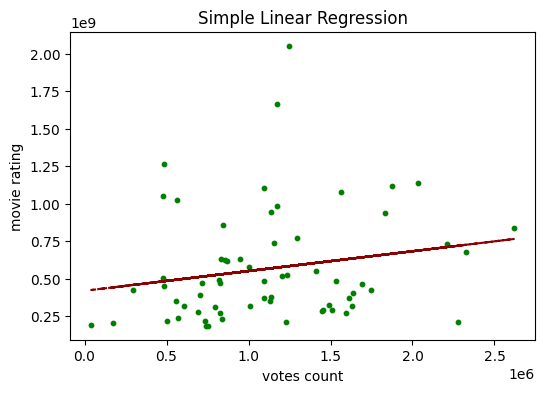

In [ ]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('votes count')
plt.ylabel('movie rating')

plt.show()

### Check model residuals

In [12]:
# Calculate model residuals for train data
residuals = y_train - mymodel

# Check the first residual value in our data set
print(f'1st Predicted rating in dataset: {mymodel[0]:.2f}')
print(f'1st Observed rating in dataset: {y_train[0]:.2f}')
print(f'1st Residual rating in dataset: {residuals[0]:.2f}')

1st Predicted rating in dataset: 493290542.68


KeyError: 0

### Plot histogram of residuals

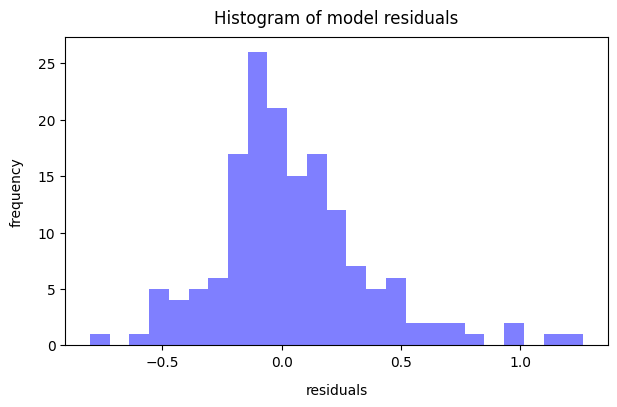

In [ ]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

# Show plot
plt.show()

### Compare the observed votes with the predicted votes

In [134]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed rating: {y_test.iloc[i]:.1f}, Predicted rating: {predicted.iloc[i]:.1f}')

Observed rating: 8.1, Predicted rating: 8.2
Observed rating: 9.0, Predicted rating: 8.6
Observed rating: 8.2, Predicted rating: 8.1
Observed rating: 8.4, Predicted rating: 8.2
Observed rating: 8.2, Predicted rating: 8.1
Observed rating: 8.1, Predicted rating: 8.2
Observed rating: 8.1, Predicted rating: 8.0
Observed rating: 8.1, Predicted rating: 8.3
Observed rating: 8.8, Predicted rating: 8.7
Observed rating: 8.2, Predicted rating: 8.0


## Multiple linear regression

### Create train and test samples (train = 80%, test = 20% of the data)

In [135]:
# Create train and test samples (we name it X2_ and y_2 because we already used X_ and y_ above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[['release_year',
                                                            'votes_count',
                                                            'runtime_(mins)']], 
                                                        df['movie_rating'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
     release_year  votes_count  runtime_(mins)
132          1926       100314              78
225          1965       268151             172
238          1948       157842              80
119          2015       841663              95
136          2009       191460              92 

y2_train:
132    8.1
225    8.1
238    7.9
119    8.1
136    8.1
Name: movie_rating, dtype: float64


### fit the regression model

In [136]:
# Add constant to the model
X2_train_const = sm.add_constant(X2_train)

# Create the multiple regression model
olsmod = sm.OLS(y2_train, X2_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:           movie_rating   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     121.8
Date:                Thu, 09 Jan 2025   Prob (F-statistic):           1.49e-44
Time:                        08:57:04   Log-Likelihood:                 97.199
No. Observations:                 200   AIC:                            -186.4
Df Residuals:                     196   BIC:                            -173.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.7956      0.962     18.

### Plot histogram of residuals

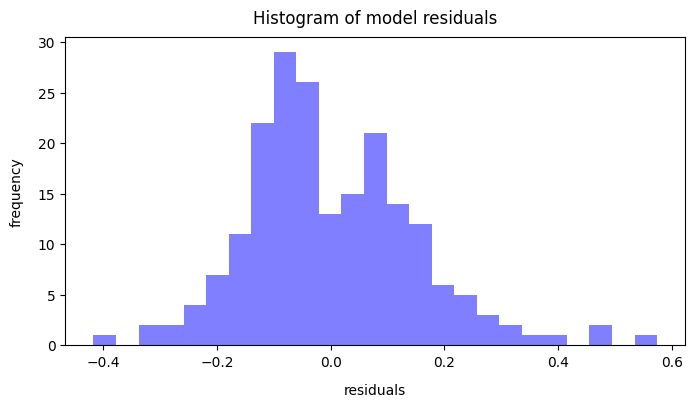

In [ ]:
# Plot histogram of residuals
fig = plt.figure( figsize=(8,4))
n, bins, patches = plt.hist(x=olsres.resid, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)

plt.show()

### Compare the observed ratings with the predicted ratings

In [138]:
# Add constant to X2_test
X2_test_const = sm.add_constant(X2_test)
predicted_new = olsres.predict(X2_test_const)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed rating: {y_test.iloc[i]:.1f}, Predicted rating: {predicted_new.iloc[i]:.1f}')

Observed rating: 8.1, Predicted rating: 8.2
Observed rating: 9.0, Predicted rating: 8.7
Observed rating: 8.2, Predicted rating: 8.1
Observed rating: 8.4, Predicted rating: 8.3
Observed rating: 8.2, Predicted rating: 8.2
Observed rating: 8.1, Predicted rating: 8.2
Observed rating: 8.1, Predicted rating: 8.3
Observed rating: 8.1, Predicted rating: 8.2
Observed rating: 8.8, Predicted rating: 8.9
Observed rating: 8.2, Predicted rating: 8.2


### Jupyter notebook --footer info--

In [139]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2025-01-09 08:57:04
Python Version: 3.11.10
-----------------------------------


###